# Q3-Multiclass Gaussian Bayes classifier (Bayesianclassification)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import math

path=r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\original dataset\crimes.csv"

data=pd.read_csv(path)

In [91]:
train_df=data[data["split"]=="TRAIN"]
val_df=data[data["split"]=="VAL"]

In [92]:
features = ["hour_float", "victim_age", "latitude", "longitude","temp_c","humidity","dist_precinct_km","pop_density"]

## Θα χρειαστούμε τα αποτελέσματα του Q2

In [93]:
def Q2(train_dataset):
    results = {}

    killers_id=sorted(train_dataset["killer_id"].unique())

    for killer_id in killers_id:
            
            temp=train_dataset[train_dataset["killer_id"]==killer_id]
            features_q2=["hour_float", "victim_age", "latitude", "longitude","temp_c","humidity","dist_precinct_km","pop_density"]
            
            
            mean_lst=[]
            N=len(temp)
            
            for feature in features_q2:
                total=0
                for record in temp[feature]:
                    total+=record
                mean=total/N
                mean_lst.append(mean)
                
            sigma_matrix=[[0,0,0,0,0,0,0,0] for _ in range(8)]
        
            records=temp[features_q2].values.tolist()
            for record in records:
                diffs=[]
                for i in range(8):
                    diffs.append(record[i]-mean_lst[i])
                
                for i in range(8):
                    for j in range(8):
                        sigma_matrix[i][j]+=diffs[i]*diffs[j]
                        
            for i in range(8):
                    for j in range(8):
                        sigma_matrix[i][j]=sigma_matrix[i][j]/N
                
            results[killer_id]={
                    "mean":mean_lst,
                    "sigma":sigma_matrix
                }
            
    test_killer=killers_id[0]
    killer_data = train_dataset[(train_dataset["split"]=="TRAIN") & (train_dataset["killer_id"]==test_killer)]
    X = killer_data[["hour_float", "victim_age", "latitude", "longitude","temp_c","humidity","dist_precinct_km","pop_density"]].values
        
    my_mu = results[test_killer]["mean"]
    my_sigma = results[test_killer]["sigma"]
        
    scipy_log_likelihood = np.sum(multivariate_normal.logpdf(X, mean=my_mu, cov=my_sigma))

    print(f"\n--- Verification for Killer {test_killer} ---")
    print(f"Scipy Log-Likelihood: {scipy_log_likelihood}")
    
    numpy_mu = np.mean(X, axis=0)
    numpy_sigma = np.cov(X, rowvar=False, bias=True) 
    
    return results

In [94]:
results=Q2(train_df)


--- Verification for Killer 1 ---
Scipy Log-Likelihood: -363.9577611027008


In [95]:
def predict_single(x,priors):
    posteriors = {}
    for k_id in priors.keys():
        mu = results[k_id]["mean"]
        sigma = results[k_id]["sigma"]
        sigma_stable = np.array(sigma) + np.eye(8) * 1e-6
            
            
        log_pdf = multivariate_normal.logpdf(x, mean=mu, cov=sigma_stable)
        posteriors[k_id] = np.log(priors[k_id]) + log_pdf
        
    return max(posteriors, key=posteriors.get)

Accuracy on TRAIN: 0.8983
Accuracy on VAL: 0.9050


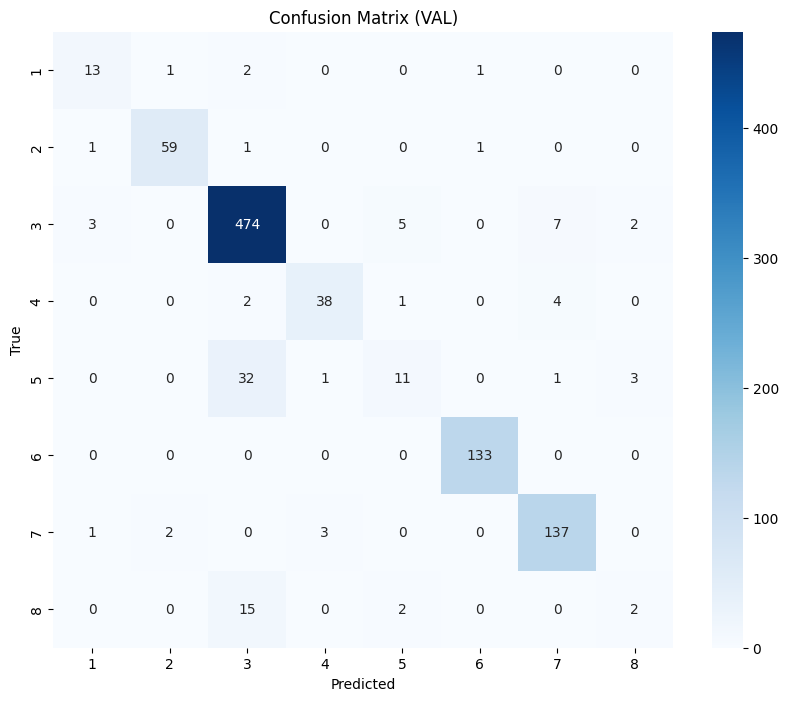

In [96]:
priors = {}
total_n = len(train_df)
killers_id = sorted(train_df["killer_id"].unique())
for k_id in killers_id:
    nk = len(train_df[train_df["killer_id"] == k_id])
    priors[k_id] = nk / total_n
    
    
for split_name, df in [("TRAIN", train_df), ("VAL", val_df)]:
    y_true = df["killer_id"].values
    X_data = df[features].values
        
    y_pred = [predict_single(row,priors) for row in X_data]
        
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy on {split_name}: {acc:.4f}")
        
    if split_name == "VAL":
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",xticklabels=killers_id, yticklabels=killers_id)
        plt.title("Confusion Matrix (VAL)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

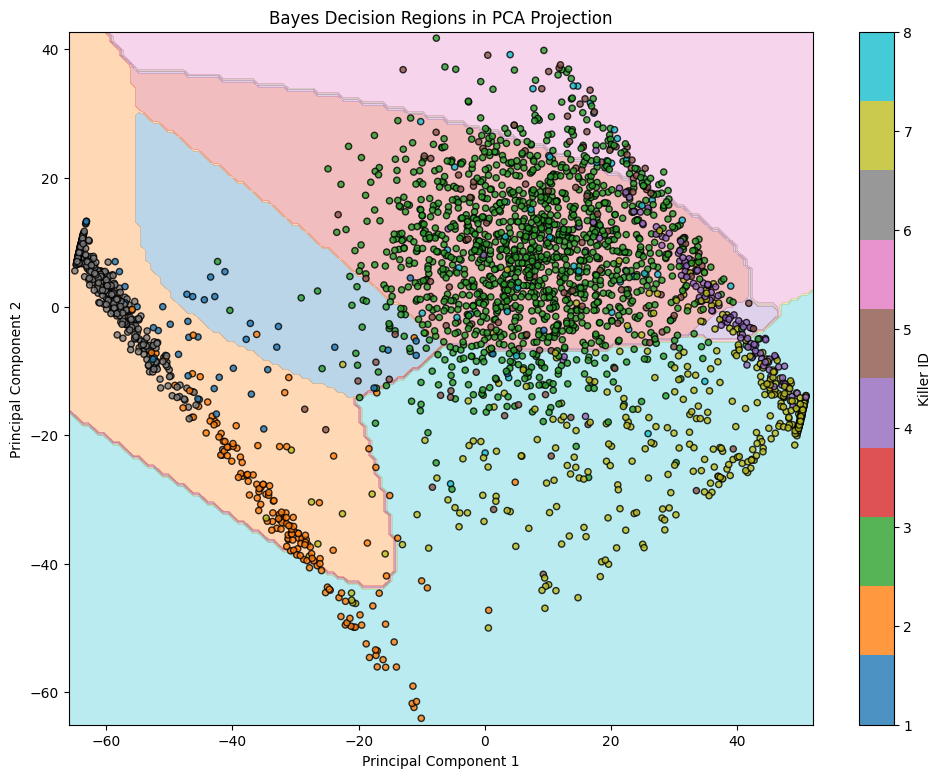

In [ ]:
from sklearn.decomposition import PCA

def plot_decision_regions_pca(train_df, priors):
    pca = PCA(n_components=2)
    X_train_8d = train_df[features].values
    X_pca = pca.fit_transform(X_train_8d)
    
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150), np.linspace(y_min, y_max, 150))
    
    grid_points_pca = np.c_[xx.ravel(), yy.ravel()]
    grid_points_8d = pca.inverse_transform(grid_points_pca)
    
    Z_classes = []
    for row in grid_points_8d:
        pred = predict_single(row, priors)
        Z_classes.append(pred)
    
    Z_classes = np.array(Z_classes).reshape(xx.shape)
    
    plt.figure(figsize=(12, 9))
    
    
    plt.contourf(xx, yy, Z_classes, alpha=0.3, cmap='tab10')
    
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_df["killer_id"], 
                         cmap='tab10', s=20, edgecolor='k', alpha=0.8)
    
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Bayes Decision Regions in PCA Projection")
    plt.colorbar(scatter, label='Killer ID')
    plt.show()

# Κλήση της νέας συνάρτησης
plot_decision_regions_pca(train_df, priors)